In [1]:
import numpy as np 
from matplotlib import pyplot as plt

# To render plots inside the Jupyter notebook
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

np.random.seed(42)

In this notebook, we'll learn how to fit a mock light curve of a transiting exoplanet
using a method for sampling the posterior probability distribution over the 
model parameters. 
The goal is to sample the posterior probability distribution over the
model parameters, conditioned on the data:

$$p(\boldsymbol \theta |\mathbf{D})=\frac{p(\mathbf{D}|\boldsymbol\theta)\,p(\boldsymbol\theta)}{p(\mathbf{D})}$$

The most popular class of algorithms which  used for generating samples from a pdf 
are called *Markov Chain Monte Carlo* algorithms or MCMC for short.
The simplest of these algorithms, and the very first one that was developed, is 
called the *Metropolis algorithm*:

**The Metropolis algorithm**

Given a most recent sample $\boldsymbol\theta^{(k)}$, to generate the next sample
- Draw a proposal $\boldsymbol\theta'$ from a proposal pdf 
 $q(\boldsymbol\theta'\lvert\boldsymbol\theta^{(k)})$ which *we know how to sample from* (i.e. 
there's a simple numpy function that does it)
- Draw a uniform random number $r\sim\mathcal{U}(0,1)$
- If $r\leq p(\boldsymbol\theta')/p(\boldsymbol\theta^{(k)})$ then 
    $\boldsymbol\theta^{(k+1)}\leftarrow\boldsymbol\theta'$ (accept proposal), else 
    $\boldsymbol\theta^{(k+1)}\leftarrow\boldsymbol\theta^{(k)}$ (reject proposal)
- Repeat until happy with the number of samples
        
The main characteristic of this algorithm is that it defines a biased random walk
through
the parameter space in such a way that we end up sampling the target pdf $p(\boldsymbol\theta)$.
As the number of samples approaches infinity, we are guaranteed that any sensible expectation
value under the pdf can be approximated by a sum over the drawn samples:

$$    \lim_{K\rightarrow\infty}\frac{1}{K}\sum_{i=1}^Kg(
    \theta^{(k)})\rightarrow\mathbb{E}_{p(\theta)}\left[g(\theta)\right]
$$

The reason why the Metropolis algorithm works is that it defines a process called a 
*Markov chain* in which the probability of moving from a current state to 
a successive state in the chain depends only on the current state and not any
past states.
Markov chains have stationary probability distributions over states and the stationary
distribution for the Markov chain defined by the Metropolis algorithm turns out to be
the target distribution $p(\boldsymbol\theta)$.
In order for the above to hold, the proposal pdf $q$ must satisfied a property
called *detailed balance*, defined by

$$
q(\boldsymbol\theta'\lvert\boldsymbol\theta)=q(\boldsymbol\theta\lvert\boldsymbol\theta')
$$

that is, it has to be reversible in the sense that the probability of transitioning from $\theta$ 
to $\theta'$ is the same as the probability of transitioning from $\theta'$ to $\theta$
for any two pairs of states $\theta$ and $\theta'$.

The simplest choice for the proposal pdf is a multivariate Gaussian distribution 
for $\boldsymbol\theta'$ with a mean $\boldsymbol\theta$ and a covariance matrix $\boldsymbol\Sigma$, or
in shorthand notation, $q(\boldsymbol\theta'\lvert\boldsymbol\theta)\sim\mathcal{N}(\boldsymbol\theta,\Sigma)$
(`np.random.multivariate_normal` in `numpy`).
The variances in the covariance matrix 
then define a characteristic step size in the parameter space for each parameter, if the step size is
too large most proposals will get rejected and the chain might miss regions of high 
probability. 
If on the other hand the step size is too small, most steps are likely to be accepted
but we might not explore the parameter space fully.

All MCMC algorithms have the same goal, namely, generating samples from a target
pdf such that the least number of samples $K$ are needed to accurately approximate
the expectation integral.
Some metrics on which MCMC samplers are judged upon are
- Efficiency - what is the acceptance rate of the proposals?
- Coverage - is the target pdf explored completely?
- Correlation - how correlated are individual samples with past samples?
- High dimensions - can the sampler handle high dimensional spaces?
- Derivatives - does the sampler require the derivatives of the likelihood with respect 
to the model parameters?

## Fitting a mock transit event

Instead of using a physical model for modeling the exoplanet transit, a model which would have to include
parameters such as the period of the planet, the ratio of its radius to the radius of the star, the impact
parameter, the eccentricity of the orbit and other physics, we'll use a mock transit model specified
by a trivial piecwise function defined as follows:

$$
\mu(t)=\left\{\begin{array}{ll}{A,} & {\left(t_{c}-w / 2\right) \leq t \leq\left(t_{c}+w / 2\right)} \\ {A-b,} & {\text { otherwise }}\end{array}\right.
$$

where $A$ is the stellar flux outside of the transit, $b$ is the depth of the transit, $t_c$ is the
time at midpoint and $w$ is the width of the transit.
The inference procedure is exactly the same using a more realistic transit
model except the function we plug into the likelihood is different and a lot more complex.

First, we'll generate  mock data using the *same model we'll use for fitting*, this will allow us
to test whether our MCMC sampler is working correctly and recovering the true parameters. Of course, in reality
we never know the true model which generated our data, it is usually far more complex than the models we
use to fit the data.

We'll take the true parameters to be:

$$\boldsymbol\theta=\{A,b,t_c,w\}=\{1.0, 0.5,4.0, 3.0\}$$

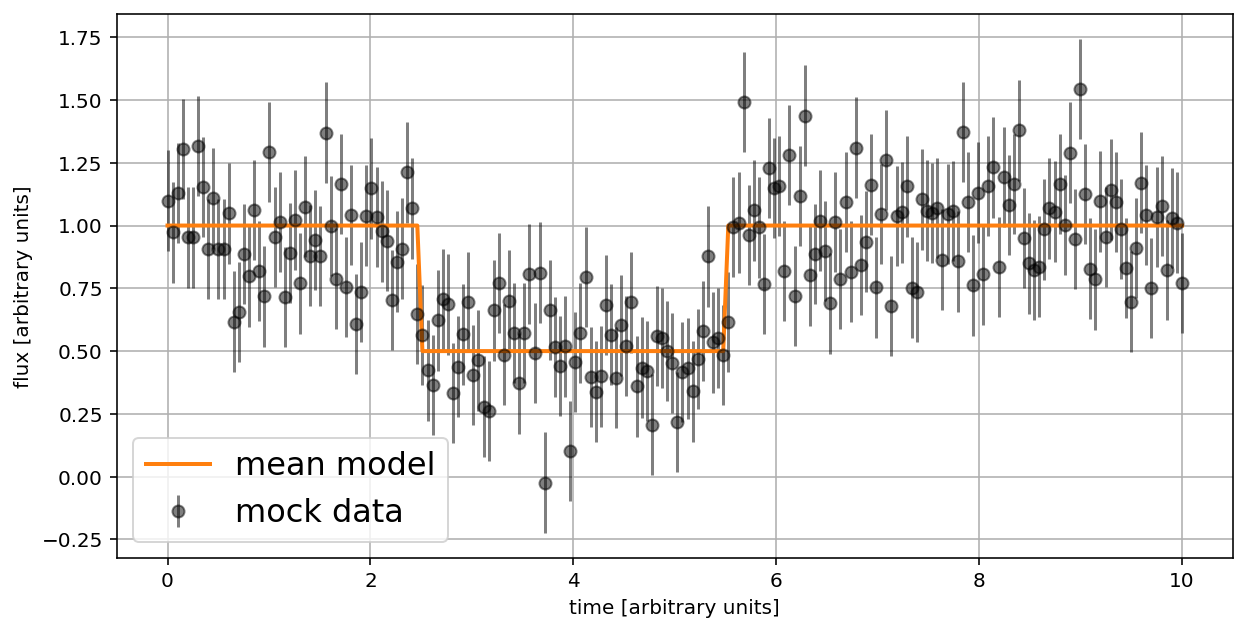

In [2]:
# Generate mock data
def mean_model(t, params):
    A, b, tc, w = params
    
    mu = A*np.ones(len(t))
    mask = (t > tc - w/2) & (t < tc + w/2)
    mu[mask] = A - b
    
    return mu

t = np.linspace(0, 10, 200)
mean_flux = mean_model(t, [1., 0.5, 4., 3.])

# Add gaussian noise
covariance_matrix = 0.2**2*np.diag(np.ones(len(t)))
sigma = np.sqrt(np.diagonal(covariance_matrix))
mock_flux = np.random.multivariate_normal(mean_flux, covariance_matrix)

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(t, mock_flux, sigma, 
            fmt='o', color='black', alpha=0.5, label='mock data')
ax.plot(t, mean_flux, color='C1', lw=2., label='mean model')
ax.grid()
ax.set_ylabel('flux [arbitrary units]')
ax.set_xlabel('time [arbitrary units]')
ax.legend(prop={'size': 16})

Now that we have the data, let's pretend we don't know the true parameters and fit a model using MCMC.
We'll assume that the likelihood $p(\mathbf{D}|\boldsymbol\theta)$ is Gaussian and that all the data 
points independently distributed with identical uncertainties $\sigma_i\equiv\sigma$ and those are known. 
The likelihood for the *i-th* data point is then

$$
p(D_i|\boldsymbol\theta)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(D_n-\mu(t_n))^2}{2\sigma^2}\right]
$$

and since we assume independance between data points, the complete likelihood is just the product
of the above factors

$$
p(\mathbf{D}|\boldsymbol\theta)=\prod_{n=1}^Np(D_n|\boldsymbol\theta)=\prod_{n=1}^N
\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(D_n-\mu(t_n))^2}{2\sigma^2}\right]
$$

and the log likelihood is

$$
\ln p(\mathbf{D}|\boldsymbol\theta)= -\frac{1}{2}N\ln(2\pi\sigma^2)-\sum_{n=1}^N
\frac{(D_n-\mu_n)^2}{2\sigma^2}
$$

We assume an independent prior over the model parameters, that is

$$
p(\boldsymbol\theta)=p(A,b,t_c,w)=p(A)\,p(b)\,p(t_c)\,p(w)
$$

and we take all priors to be [uniform](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous))
in some range.

In the code, we need to implement the following functions: `log_prior`, `log_likelihood`, `log_posterior` and `sample`.
For now, we'll use uniform priors for all of the parameters, this is generally a bad idea but it won't matter
much in this example. The priors should return `-np.inf` outside of the parameter regions of interest.



In [11]:
def log_prior(params):
    """
    Computes the natural logarithm of the join prior distribution
    over all of the model parameters ln_p(theta1, ..., theta_N).
    We assume an independent uniform prior over all parameters.
    
    Parameters
    ----------
    params : list
        List containing model parameters: [A, B, tc, w]
        
    Returns
    -------
    float
        Natural logarithm of the joint prior pdf.
    """
    # Unpack the parameters
    A, b, tc, w  = params
    
    # Uniform priors for all parameters
    if (A < 0) or (A > 2.):
        return -np.inf # negative infinity
    elif (b < 0) or (b > 1.):
        return -np.inf 
    elif (tc < 0) or (tc > 10.):
        return -np.inf 
    elif (w < 0) or (w > 10.):
        return -np.inf 
    
    # If all the parameters are within the bounds, return a constant. 
    # In principle we should return the log-pdf but for a uniform pdf
    # that's just a constant factor and MCMC doesn't care about 
    # normalization
    else:
        return 0. 
    
def log_likelihood(params, t, flux, sigma):
    """
    Computes the natural logarithm of the (Gaussian) likelihood 
    function.
    
    Parameters
    ----------
    params : list
        List containing model parameters: [A, B, tc, w]
    t : ndarray
        Numpy array of times at which observations were taken
    flux : ndarray
        Numpy array of fluxes observed at those times. Needs to have
        the same shape as t. 
    sigma : ndarray
        Numpy array containing the uncertainties assoiciated with each 
        data point (so called "error bars").
        
    Returns
    -------
    float
        Natural logarithm of the likelihood.
    """
    # Unpack the parameters
    A, b, tc, w  = params
    
    N = float(len(t)) # nr of data points
    
    # Compute the mean model for given parameters
    prediction = mean_model(t, params)
    
    # Compute residuals with respect to mean model
    r = flux - prediction
        
    # Compute the log likelihood
    ln_L = -0.5*N*np.sqrt(2*np.pi*sigma[0]) - 0.5*np.sum(r**2/sigma**2)
        
    return ln_L 
    
def log_posterior(params, t, flux, sigma):
    """
    Computes the natural logarithm of the posterior pdf.
    
    Parameters
    ----------
    params : list
        List containing model parameters: [A, B, tc, w]
    t : ndarray
        Numpy array of times at which observations were taken
    flux : ndarray
        Numpy array of fluxes observed at those times. Needs to have
        the same shape as t. 
    sigma : ndarray
        Numpy array containing the uncertainties assoiciated with each 
        data point (so called "error bars").
        
    Returns
    -------
    float
        Natural logarithm of the posterior pdf.
    """
    ln_prior = log_prior(params)
    
    if np.isinf(ln_prior):
        return ln_prior
    else:           
        ln_likelihood = log_likelihood(params, t, flux, sigma)
        return ln_prior + ln_likelihood
    
def proposal_distribution(params, sigmas):
    """
    Returns a sample from the proposal distribution q(theta'|theta).
    
    Parameters
    ----------
    params : list
        List containing model parameters: [A, B, tc, w]
    sigmas : list
        Array of size len(params) containing the diagonal elements 
        square roots of the variances on the diagonal in a multivariate
        gaussian distribution.
    
    Returns
    -------
    float
        Natural logarithm of the likelihood.
    """
    # Generate a proposal
    step = np.random.multivariate_normal(np.zeros(len(params)),
                                        np.diag(sigmas))

    return params + step
    
def sample(initial_params, n_steps, sigmas):
    """
    Uses the Metropolis algorithm to sample the posterior pdf.
    
    Parameters
    ----------
    initial_params : list
        List containing initial values of model parameters: [A, B, tc, w]
    n_steps : int
        Number of sampling steps we want to use.
    sigmas
    
    Returns
    -------
    ndarray
        Array of shape (n_steps, n_params) containing the posterior samples.
    """
    # Evaluate the log posterior for the inital parameters
    logp = log_posterior(initial_params, t, mock_flux, sigma)
        
    # Create array for storing the samples
    samples = np.zeros((n_steps, len(initial_params)))
    
    # Main loop
    params = initial_params
    
    # Keep track of the number of accepted vs. rejected steps
    n_accepted = 0
    
    for i in range(n_steps): 
        # Draw new parameters from a proposal distribution
        new_params = proposal_distribution(params, sigmas)
                
        # Evaluate the posterior for the proposal
        logp_new = log_posterior(new_params, t, mock_flux, sigma)
            
        # Accept
        r = np.random.rand() # Uniform number r ~ U(0, 1)
        if r <= np.exp(logp_new - logp):
            params = new_params
            logp = logp_new
            n_accepted += 1
            
        samples[i] = params
        
    print("Acceptance rate: ", float(n_accepted)/float(n_steps))
            
    return samples

In [12]:
# Set up the initial position of the chain (initial parameters)
initial_params = [0.5, 0.5, 0.5, 0.5]

sigmas = [0.0005, 0.0005, 0.005, 0.005]

# Call the sample function
samples = sample(initial_params, 10000, sigmas)

Acceptance rate:  0.1072


## Plot the chains

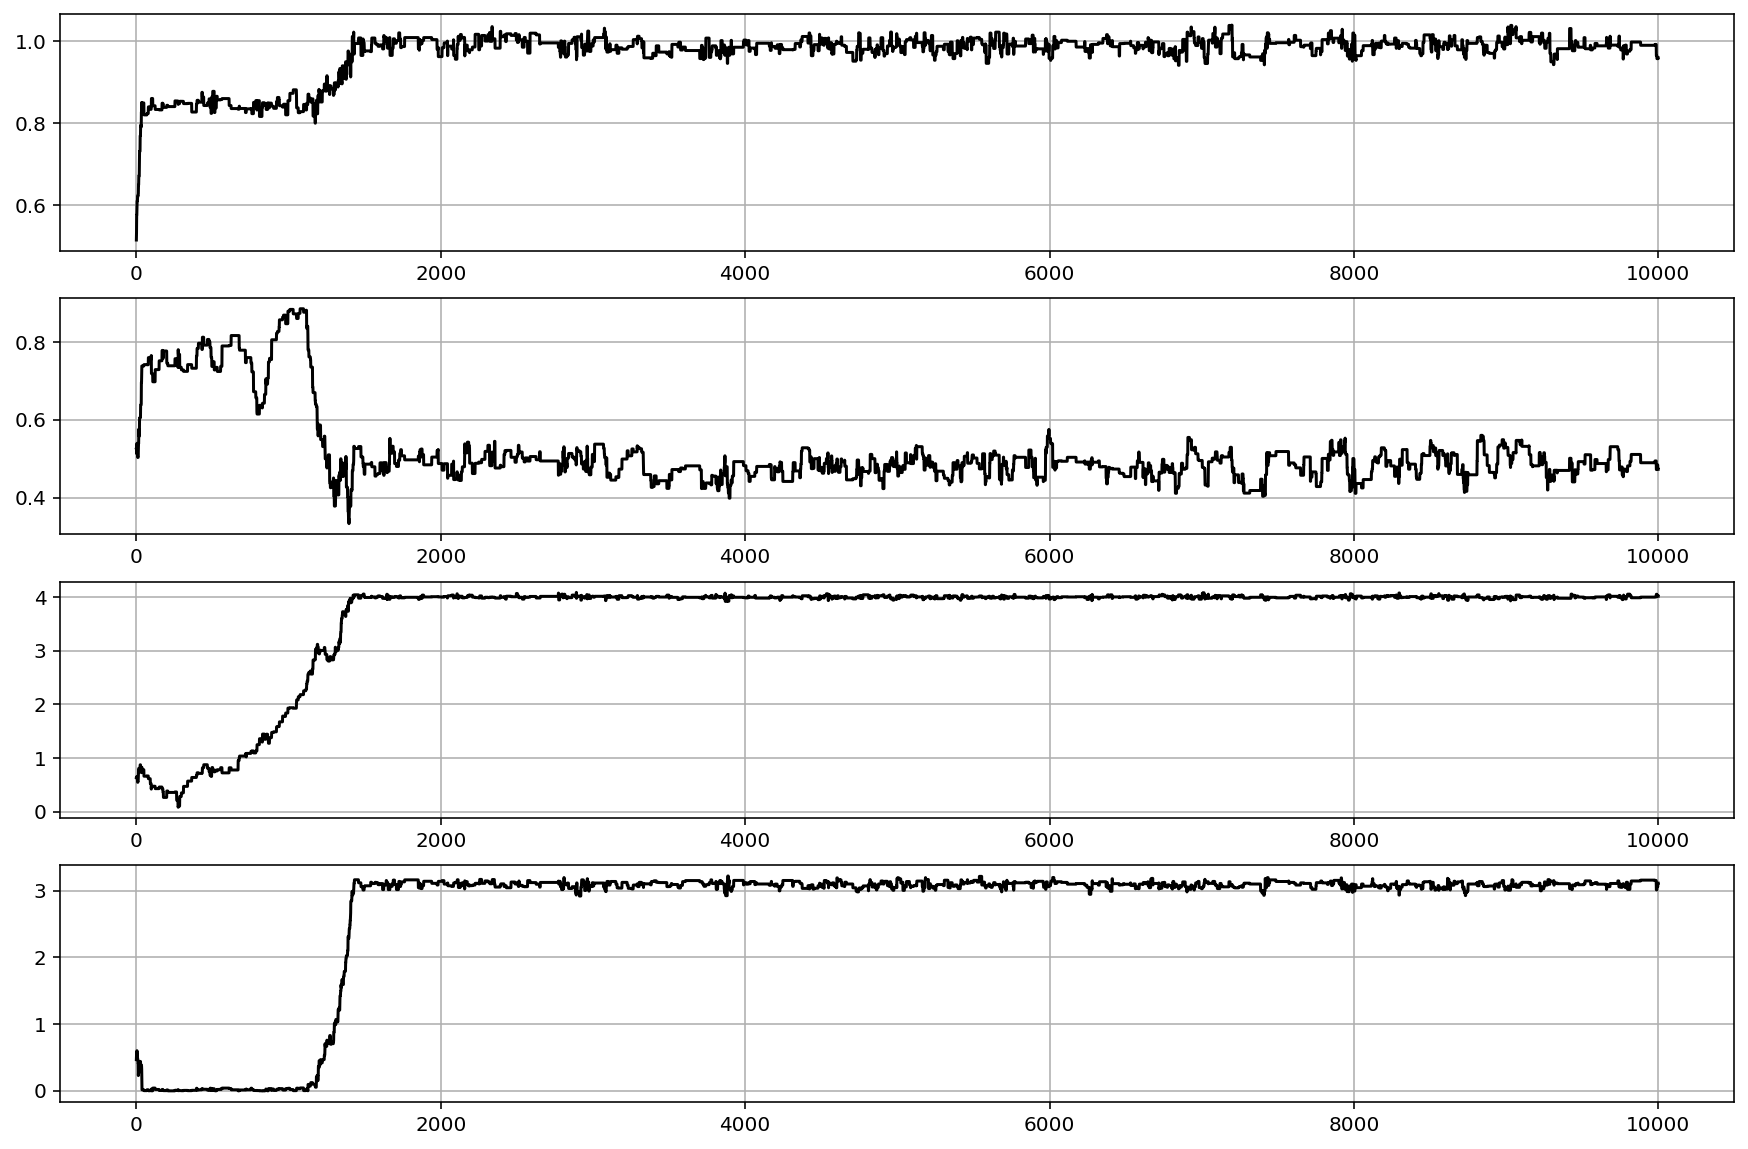

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10))

for i in range(4):
    ax[i].plot(samples[:, i], color='black')
    ax[i].grid()

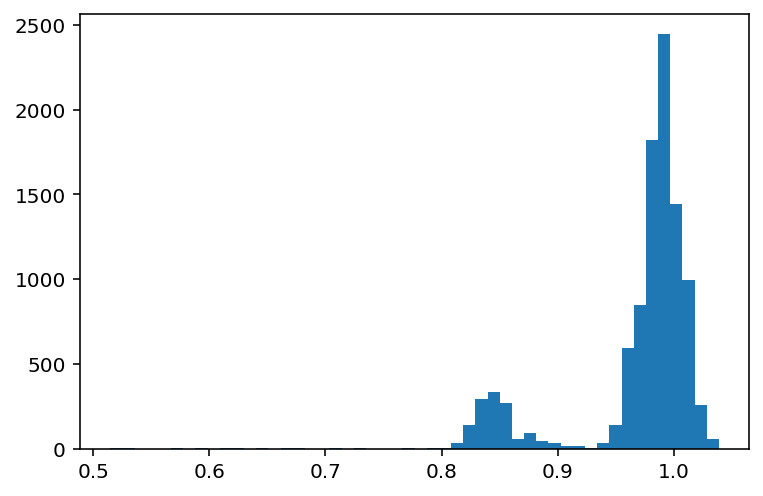

In [15]:
fig, ax = plt.subplots()

ax.hist(samples[:, 0], bins=50);

## Plot posterior samples in data space

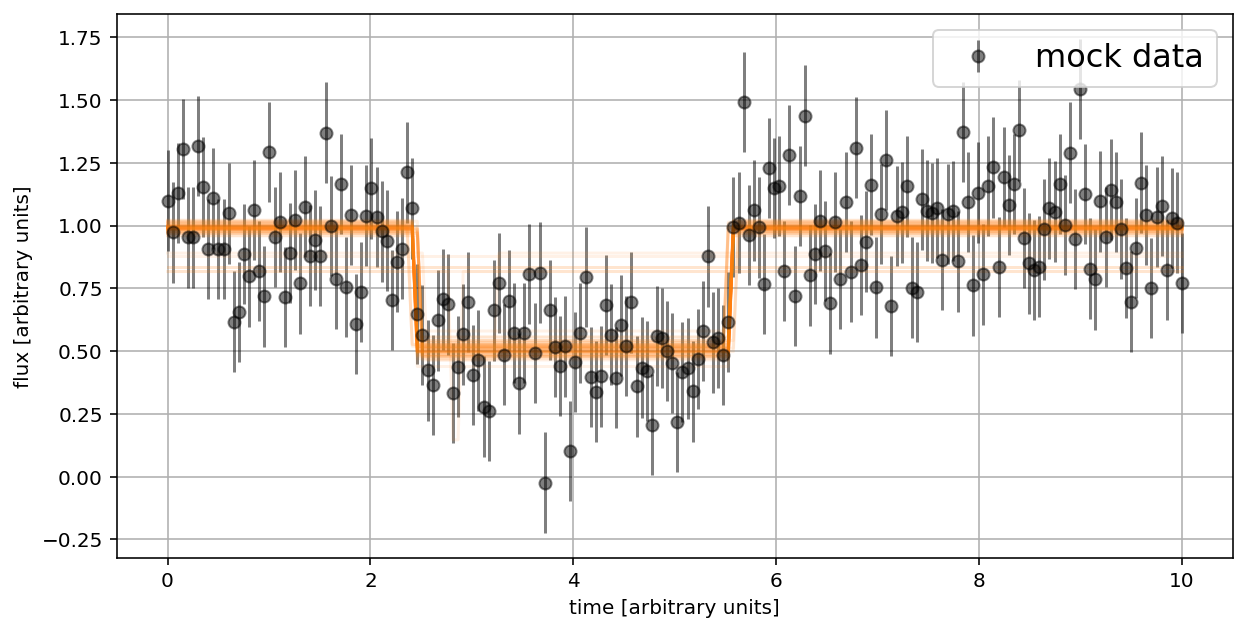

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(t, mock_flux, sigma, 
            fmt='o', color='black', alpha=0.5, label='mock data')
ax.grid()
ax.set_ylabel('flux [arbitrary units]')
ax.set_xlabel('time [arbitrary units]')
ax.legend(prop={'size': 16})


for params in samples[np.random.randint(len(samples), size=60)]:
    model_prediction = mean_model(t, params)
    ax.plot(t, model_prediction, color='C1', label='mean model', alpha=0.1)
